# Main

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

RuntimeError: module compiled against API version 0xa but this version of numpy is 0x9

ImportError: numpy.core.multiarray failed to import

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from glob import glob
#from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [3]:
from model import *
from data import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
graph_path = './data/maps/paths/'
node_path = './data/maps/nodes/'
trn_fnames = next(os.walk('./data/maps/train/dist/'))[2]
trn_inpath = './data/maps/train/dist/'
trn_outpath = './data/maps/train/target/'

val_fnames = next(os.walk('./data/maps/valid/dist/'))[2]
val_inpath = './data/maps/valid/dist/'
val_outpath = './data/maps/valid/target/'

tst_fnames = next(os.walk('./data/maps/test/dist/'))[2]
tst_inpath = './data/maps/test/dist/'

## Dataset

In [81]:
norms = (3.0482845, 0.27204284)
type_norms = [(47.479884, 10.922172), (94.976153, 18.277237), (-0.270624, 4.523611), 
             (3.688470, 3.070907), (-10.286605, 3.979607), (0.990730, 1.315393),
             (3.124754, 1.315393), (4.771023, 3.704984)]

In [389]:
trn_data = MolData(trn_fnames, trn_inpath, graph_path, node_path, trn_outpath, 29, norms=norms)
val_data = MolData(val_fnames[:128], val_inpath, graph_path, node_path, val_outpath, 31, norms=norms)
tst_data = MolData(tst_fnames, tst_inpath, graph_path, node_path, None, pad_size=None, norms=norms)

Max dist = 3.9244  
Max recept = 29

Train max distance = 3.9244
Valid max distance = 3.8807
Test max distance = 3.9244

In [390]:
train = DataLoader(trn_data, batch_size=128, shuffle=True)
valid = DataLoader(val_data, batch_size=128, shuffle=False)
test = DataLoader(tst_data, batch_size=1)

In [391]:
for ix, data in enumerate(test):
    print(data['distance'].size(), data['target'].size())
    if ix == 0:
        break

torch.Size([1, 15, 15]) torch.Size([1, 15, 15])


## Model

In [401]:
from model import *

In [402]:
gcn = SemGCN(3, 5, inplanes=128, n_blocks=36, dilations=[1, 2, 3])
#model.load_state_dict(torch.load('./models/augs1.pt'))
#loss = SmoothL1Types()
loss = MSETypes()
#loss = MSE()
optim = torch.optim.Adam

In [403]:
%%capture
gcn.load_state_dict(torch.load('./models/semgcn_1c_22k.pt'))

In [404]:
learner = Learner(gcn, loss, optim, train, valid=valid)

In [405]:
#learner.range_test(1e-5, 1, 100, smooth_f=0)

In [406]:
#save_path = './models/semgcn_1c_22k.pt'
#learner.training(epochs=1, iters=1, lr=1e-3, save_path=None)
#learner.train_one_cycle(200, 1e-2, eval_iters=100, save_path=None)
#learner.evaluate()

In [407]:
#torch.save(learner.model.state_dict(), './models/test.pt')

In [408]:
test_df = pd.read_csv('./data/test.csv')
subm = learner.create_submission(test, test_df)
subm.to_csv('./results/semgcn_1c_22k_29.csv')
subm.head()

100%|██████████| 45772/45772 [1:04:29<00:00, 11.83it/s]


,scalar_coupling_constant
id,
4658147,5.216179
4658148,150.591476
4658149,5.225959
4658150,150.591492
4658151,5.216181


### Testing

In [43]:
batch = iter(valid).next()
output, target = learner.batch_predict(batch)
types = batch['type']

In [50]:
x = 1
idx = np.random.choice(range(len(target)))
t = types[idx]

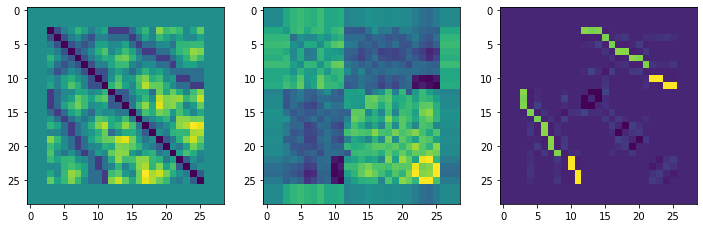

In [51]:
f, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].imshow(batch['distance'][idx])
ax[1].imshow(output[idx, x-1])
ax[2].imshow(target[idx, 0])